# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms using the per-channel mean and standard deviation of the training set, which are 0.1307 and 0.3081, respectively: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
# Also apply data augmentation by rotating the images randomly by up to 10 degrees
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.RandomRotation(10)])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The ToTensor() transform converts the image to a tensor and normalizes the pixel values to be between 0 and 1. I chose to normalize the data because it ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Here, I applied the mean and standard deviation of the MNIST training set given in https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457. In addition, I applied random rotation and translation to the training set to increase the number of training examples and to make the model more robust to these transformations. For the test set, I only applied normalization to see how the model performs on the original test set without any augmentation.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


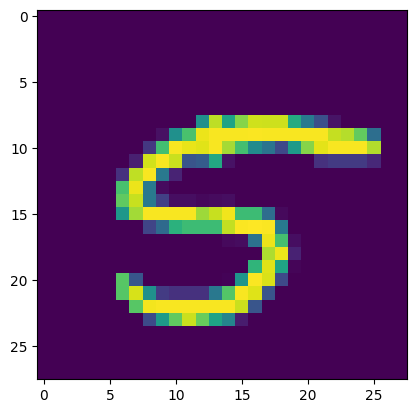

5


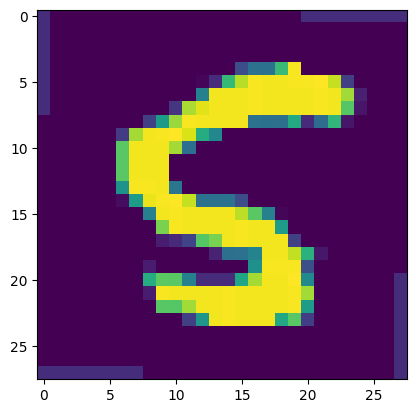

6


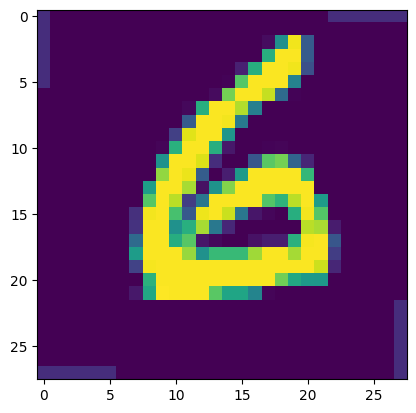

1


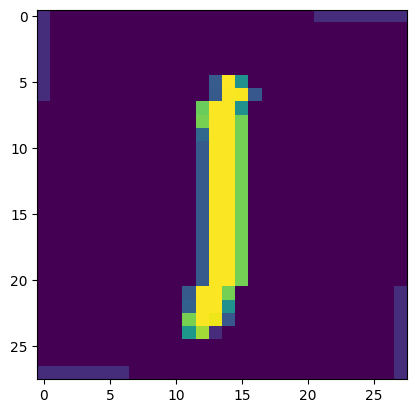

2


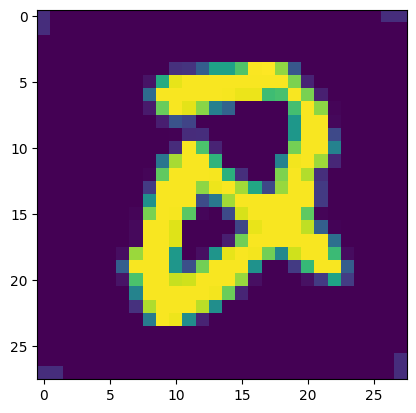

In [4]:
# Explore data
show5(train_loader)

In [5]:
# Print the shape of the training set and test set
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
# Define the network to classify the MNIST dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten the output from convolutional layers
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Apply softmax to output a probability distribution over the 10 classes
        x = F.softmax(x, dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Create an instance of the CNN model
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
# Define the device as the first visible cuda device if we have CUDA available: otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the network and the optimizer to the device
model.to(device)

# Define the number of epochs to train for
n_epochs = 6

# Define the lists to store the results of loss and accuracy
train_losses = []
train_accs = []

# Loop over the epochs
for epoch in range(n_epochs):
    # Set the training mode ON -> Activate Dropout Layers
    model.train()

    # Define the train loss and the number of correct predictions
    train_loss = 0.0
    n_correct = 0.0

    # Loop over the batches
    for i, data in enumerate(train_loader):
        # Get the inputs and the labels
        inputs, labels = data

        # Move them to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Add the batch loss to the train loss
        train_loss += loss.item()

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Count the correct predictions
        n_correct += (predicted == labels).sum().item()

        # Print the average loss every 250 batches
        if i % 250 == 249:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, train_loss / 250))

            # Reset the train loss
            train_loss = 0.0

    # Append the average train loss and train accuracy to the lists
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(n_correct / len(trainset))

    # Print the average train loss and train accuracy after each epoch
    print('Epoch %d: Train loss: %.3f, Train accuracy: %.3f' % (epoch + 1, train_loss / len(train_loader), n_correct / len(trainset)))

[1,   250] loss: 1.662
Epoch 1: Train loss: 0.701, Train accuracy: 0.878
[2,   250] loss: 1.493
Epoch 2: Train loss: 0.694, Train accuracy: 0.973
[3,   250] loss: 1.483
Epoch 3: Train loss: 0.692, Train accuracy: 0.980
[4,   250] loss: 1.479
Epoch 4: Train loss: 0.691, Train accuracy: 0.982
[5,   250] loss: 1.476
Epoch 5: Train loss: 0.690, Train accuracy: 0.985
[6,   250] loss: 1.474
Epoch 6: Train loss: 0.689, Train accuracy: 0.987


Plot the training loss (and validation loss/accuracy, if recorded).

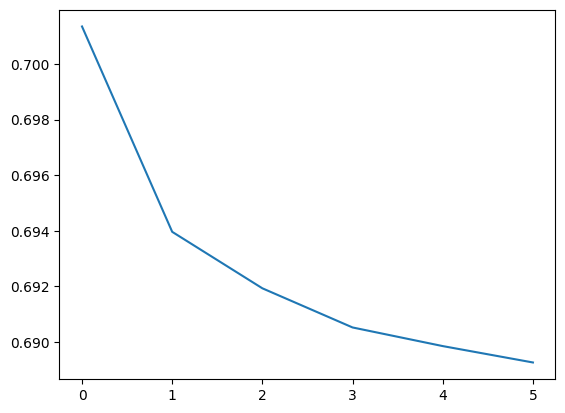

In [9]:
# Plot the loss curve
plt.plot(train_losses, label='Train loss')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
# Test the model on the test set
# Set the evaluation mode ON -> Deactivate Dropout Layers
model.eval()

# Define the test loss and the number of correct predictions
test_loss = 0.0
n_correct = 0.0

# Loop over the test set
for i, data in enumerate(test_loader):
    # Get the inputs and the labels
    inputs, labels = data

    # Move them to the GPU if available
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(inputs)

    # Calculate the loss
    loss = criterion(outputs, labels)

    # Add the batch loss to the test loss
    test_loss += loss.item()

    # Get the predicted class with the highest score
    _, predicted = torch.max(outputs.data, 1)

    # Count the correct predictions
    n_correct += (predicted == labels).sum().item()

# Print the test loss and test accuracy
print('Test loss: %.3f, Test accuracy: %.3f' % (test_loss / len(test_loader), n_correct / len(testset)))

Test loss: 1.472, Test accuracy: 0.990


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
# Save the model
torch.save(model.state_dict(), 'mnist_cnn.pt')